Now you can run the previous cell to import `torch` and `make_dot`.

Replicate original script

In [1]:
import tensorflow as tf
## reduce GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
!pip install medmnist==3.0.1 \
    torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator

import torchattacks
from torchattacks import PGD, FGSM

In [ ]:
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)
print("Medmnist", medmnist.__version__)

PyTorch 2.6.0+cu124
Torchvision 0.21.0+cu124
Torchattacks 3.5.1
Numpy 2.0.2
Medmnist 3.0.1


##Dataset

In [4]:
# from torchvision.transforms.transforms import Resize
# # [tissuemnist, pathmnist, chestmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
# # --- Helper to create a single batch with all classes ---
# def get_one_batch_with_all_classes(dataset, num_classes, batch_size=32):
#     loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
#     all_inputs, all_targets = [], []
#     seen_classes = set()

#     for x, y in loader:
#         all_inputs.append(x)
#         all_targets.append(y)
#         seen_classes.update(y.squeeze().tolist())

#         if len(seen_classes) == num_classes:
#             # Combine into one batch
#             all_inputs = torch.cat(all_inputs, dim=0)
#             all_targets = torch.cat(all_targets, dim=0)
#             return [(all_inputs, all_targets)]
#     raise ValueError(f"Could not find all {num_classes} classes in the dataset.")
# def data_input_loading(data_flag = 'pathmnist', BATCH_SIZE = 15,
#                        lr = 0.0005, NUM_EPOCHS = 5, ):
#   data_flag = data_flag
#   download = True
#   NUM_EPOCHS = NUM_EPOCHS
#   BATCH_SIZE = BATCH_SIZE
#   lr = lr
#   info = INFO[data_flag]
#   task = info['task']
#   n_channels = info['n_channels']
#   n_classes = len(info['label'])
#   DataClass = getattr(medmnist, info['python_class'])
#   # preprocessing
#   train_transform = transforms.Compose([
#       transforms.Resize(224),
#       transforms.Lambda(lambda image: image.convert('RGB')),
#       torchvision.transforms.AugMix(),
#       transforms.ToTensor(),
#       transforms.Normalize(mean=[.5], std=[.5])
#   ])
#   test_transform = transforms.Compose([
#       transforms.Resize(224),
#       transforms.Lambda(lambda image: image.convert('RGB')),
#       transforms.ToTensor(),
#       transforms.Normalize(mean=[.5], std=[.5])
#   ])

#   # load the data
#   train_dataset = DataClass(split='train', transform=train_transform, download=download)
#   test_dataset = DataClass(split='test', transform=test_transform, download=download)
#   # encapsulate data into dataloader form
#   train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#   # evaluation loaders (only one batch with all classes)
#   train_loader_at_eval = get_one_batch_with_all_classes(train_dataset, n_classes, batch_size=2*BATCH_SIZE)
#   test_loader = get_one_batch_with_all_classes(test_dataset, n_classes, batch_size=2*BATCH_SIZE)
#   return data_flag, NUM_EPOCHS, BATCH_SIZE, lr, task, train_loader, train_loader_at_eval, test_loader, n_classes

In [ ]:

# data_flag = 'pathmnist'
# BATCH_SIZE = 15
# lr = 0.0005
# NUM_EPOCHS = 5
# data_flag, NUM_EPOCHS, BATCH_SIZE, lr, task, train_loader, train_loader_at_eval, test_loader, n_classes = data_input_loading(data_flag, BATCH_SIZE, lr, NUM_EPOCHS)

In [ ]:
# len(train_loader), len(train_loader_at_eval), len(test_loader)

(6000, 1, 1)

In [4]:
### lower down sample: 1000 sample
from torch.utils.data import Subset, random_split, DataLoader
from torchvision import transforms
import torchvision
import random
import torch
import medmnist
from medmnist import INFO

# --- Helper to create a single batch with all classes ---
def get_one_batch_with_all_classes(dataset, num_classes, batch_size=32):
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
    all_inputs, all_targets = [], []
    seen_classes = set()

    for x, y in loader:
        all_inputs.append(x)
        all_targets.append(y)
        seen_classes.update(y.squeeze().tolist())

        if len(seen_classes) == num_classes:
            all_inputs = torch.cat(all_inputs, dim=0)
            all_targets = torch.cat(all_targets, dim=0)
            return [(all_inputs, all_targets)]
    raise ValueError(f"Could not find all {num_classes} classes in the dataset.")

def data_input_loading(data_flag='pathmnist', BATCH_SIZE=15, lr=0.0005, NUM_EPOCHS=5, total_samples=1000):
    download = True
    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])
    DataClass = getattr(medmnist, info['python_class'])

    # preprocessing
    train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.Lambda(lambda image: image.convert('RGB')),
        torchvision.transforms.AugMix(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])
    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.Lambda(lambda image: image.convert('RGB')),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

    # Load full dataset first (train + test combined)
    full_dataset = DataClass(split='train', transform=train_transform, download=download)
    test_dataset_full = DataClass(split='test', transform=test_transform, download=download)
    combined_dataset = torch.utils.data.ConcatDataset([full_dataset, test_dataset_full])

    # ✅ Randomly select only total_samples items
    indices = random.sample(range(len(combined_dataset)), total_samples)
    small_dataset = Subset(combined_dataset, indices)

    # ✅ Split into train / val / test (e.g., 70/15/15 split)
    train_size = int(0.7 * total_samples)
    val_size = int(0.15 * total_samples)
    test_size = total_samples - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(small_dataset, [train_size, val_size, test_size])

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_loader_at_eval = get_one_batch_with_all_classes(train_dataset, n_classes, batch_size=2*BATCH_SIZE)
    test_loader = get_one_batch_with_all_classes(test_dataset, n_classes, batch_size=2*BATCH_SIZE)

    return data_flag, NUM_EPOCHS, BATCH_SIZE, lr, task, train_loader, train_loader_at_eval, test_loader, n_classes


## Model loader

In [5]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [6]:
from MedViT import MedViT_small

# model = MedViT_small(num_classes = n_classes).to(device)
# model = MedViT_small(num_classes = n_classes).cuda()
#model = MedViT_base(num_classes = n_classes).cuda()
#model = MedViT_large(num_classes = n_classes).cuda()

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


## Train

### Team7: Modify script to continue train by loading history

In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd

# evaluation
def getAUC(y_true, y_score, task):
    """AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    """
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        auc = 0
        for i in range(y_score.shape[1]):
            label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
            auc += label_auc
        ret = auc / y_score.shape[1]
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = roc_auc_score(y_true, y_score)
    else:
        auc = 0
        for i in range(y_score.shape[1]):
            y_true_binary = (y_true == i).astype(float)
            y_score_binary = y_score[:, i]
            auc += roc_auc_score(y_true_binary, y_score_binary)
        ret = auc / y_score.shape[1]

    return ret


def getACC(y_true, y_score, task, threshold=0.5):
    """Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    """
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    if task == "multi-label, binary-class":
        y_pre = y_score > threshold
        acc = 0
        for label in range(y_true.shape[1]):
            label_acc = accuracy_score(y_true[:, label], y_pre[:, label])
            acc += label_acc
        ret = acc / y_true.shape[1]
    elif task == "binary-class":
        if y_score.ndim == 2:
            y_score = y_score[:, -1]
        else:
            assert y_score.ndim == 1
        ret = accuracy_score(y_true, y_score > threshold)
    else:
        ret = accuracy_score(y_true, np.argmax(y_score, axis=-1))

    return ret

def test(data_loader, model, criterion, task):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    data_loader = data_loader
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)
            total_loss += loss.item()
            num_batches += 1

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
        avg_loss = total_loss / num_batches

        return auc, acc ,avg_loss #, y_true, y_score


def load_or_initialize_model(model_class, model_name, optimizer_class, lr, momentum, n_classes, task):
    model_dir = "./history_record"
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f"{model_name}.pth")
    history_path = os.path.join(model_dir, f"{model_name}.csv")


    model = MedViT_small(num_classes = n_classes).to(device)

    optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum)

    start_epoch = 0
    best_val_auc = 0
    history = {
        "train_auc": [], "train_acc": [],
        "val_auc": [], "val_acc": [],
        "train_loss": [], "val_loss": []
    }

    if os.path.exists(model_path) and os.path.exists(history_path):
        print(f"Loading existing model: {model_name}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        history = pd.read_csv(history_path).to_dict(orient='list')
        start_epoch = len(history["train_loss"])
        best_val_auc = max(history["val_auc"]) if history["val_auc"] else 0

    return model, optimizer, history, start_epoch, best_val_auc
def training_and_record(model_class,
                        model_name,
                        NUM_EPOCHS, lr,
                        momentum, train_loader,
                        train_loader_at_eval,
                        test_loader,
                        n_classes,
                        task,
                        steps):
    model, optimizer, history, start_epoch, best_val_auc = load_or_initialize_model(
        model_class, model_name, optimizer_class=torch.optim.SGD, lr=lr, momentum=momentum, n_classes = n_classes,
        task = task
    )
    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    total_loss = 0
    step_count = 0  # counter for batch steps
    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        print(f'\nEpoch [{epoch + 1}/{start_epoch + NUM_EPOCHS}]')
        model.train()

        for inputs, targets in tqdm(train_loader):
            step_count += 1
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            unique_classes = np.unique(targets.cpu().numpy())
            # print(f"Unique class in target data batch is: {unique_classes.tolist()}  | Count: {len(unique_classes)}")
            if task == 'multi-label, binary-class':
                # print("Going to multi-label, bunary-class branch")
                # Ensure targets become [B, n_classes] float
                targets = torch.nn.functional.one_hot(
                    targets.squeeze().long(), num_classes=n_classes
                ).float().to(device)
                # print("target shape of original data before loss ", targets.shape)
                # print("output shape after model, before loss: ", outputs.shape)
                loss = criterion(outputs, targets)
            else:
                # print("going to ther branch")
                targets = targets.squeeze().long()  # labels become long
                # print("target shape of original data before loss ", targets.shape)
                # print("output shape after model, before loss: ", outputs.shape)
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            # stop after 20 steps per epoch
            # if step_count >= steps:
            #     print(f"Breaking after {step_count} steps in this epoch.")
            #     break

        torch.cuda.empty_cache()

        # Logging
        train_loss = total_loss / len(train_loader)
        # validation loss
        val_auc, val_acc, val_loss = test(test_loader, model, criterion, task)
        # train loss
        train_auc, train_acc, train_loss = test( train_loader_at_eval, model, criterion, task)


        history["train_auc"].append(train_auc)
        history["train_acc"].append(train_acc)
        history["train_loss"].append(train_loss)
        history["val_auc"].append(val_auc)
        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)


        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            print("📌 New best AUC — saving model")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, f"./history_record/{model_name}.pth")

        pd.DataFrame(history).to_csv(f"./history_record/{model_name}.csv", index=False)

    print("✅ Training complete.")
    return history



In [8]:
data_flag = 'pathmnist'
BATCH_SIZE = 15
lr = 0.0005
NUM_EPOCHS = 5
data_flag, NUM_EPOCHS, BATCH_SIZE, lr, task, train_loader, train_loader_at_eval, test_loader, n_classes = data_input_loading(data_flag, BATCH_SIZE, lr, NUM_EPOCHS)

100%|██████████| 206M/206M [00:11<00:00, 18.6MB/s]


In [11]:
len(train_loader), len(train_loader_at_eval), len(test_loader)

(47, 1, 1)

In [ ]:

history = training_and_record(
    model_class=MedViT_small,
    model_name=f"MedViT2D_{data_flag}",
    NUM_EPOCHS=10,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    steps = len(train_loader)
)


initialize_weights...

Epoch [1/10]


100%|██████████| 47/47 [14:43<00:00, 18.80s/it]


📌 New best AUC — saving model

Epoch [2/10]


100%|██████████| 47/47 [14:51<00:00, 18.98s/it]


📌 New best AUC — saving model

Epoch [3/10]


100%|██████████| 47/47 [14:36<00:00, 18.66s/it]


📌 New best AUC — saving model

Epoch [4/10]


100%|██████████| 47/47 [14:32<00:00, 18.56s/it]



Epoch [5/10]


100%|██████████| 47/47 [14:45<00:00, 18.84s/it]



Epoch [6/10]


100%|██████████| 47/47 [14:51<00:00, 18.97s/it]



Epoch [7/10]


 38%|███▊      | 18/47 [06:15<10:04, 20.85s/it]

In [6]:
#[tissuemnist, pathmnist, chestmnist, dermamnist, octmnist,
# pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
data_flag = 'dermamnist'
BATCH_SIZE = 15
lr = 0.0005
NUM_EPOCHS = 5
data_flag, NUM_EPOCHS, BATCH_SIZE, lr, task, train_loader, train_loader_at_eval, test_loader, n_classes = data_input_loading(data_flag, BATCH_SIZE, lr, NUM_EPOCHS)

100%|██████████| 19.7M/19.7M [00:01<00:00, 14.9MB/s]


In [12]:
data_flag

'dermamnist'

In [13]:

history = training_and_record(
    model_class=MedViT_small,
    model_name=f"MedViT2D_{data_flag}",
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes,
    task = task,
    step_count = 40
)


initialize_weights...

Epoch [1/5]


  0%|          | 0/468 [00:26<?, ?it/s]

Breaking after 1 steps in this epoch.


📌 New best AUC — saving model

Epoch [2/5]


  0%|          | 0/468 [00:19<?, ?it/s]

Breaking after 2 steps in this epoch.


📌 New best AUC — saving model

Epoch [3/5]


  0%|          | 0/468 [00:21<?, ?it/s]

Breaking after 3 steps in this epoch.


📌 New best AUC — saving model

Epoch [4/5]


  0%|          | 0/468 [00:18<?, ?it/s]

Breaking after 4 steps in this epoch.


📌 New best AUC — saving model

Epoch [5/5]


  0%|          | 0/468 [00:18<?, ?it/s]

Breaking after 5 steps in this epoch.


✅ Training complete.


## Team7: Now fit into our dataset

In [ ]:
# from step1Preprocessing import DATALOAD
# xu = DATALOAD("mri", load_mode= "pytorch", train_control_sample=100,val_control_sample=20 )
# xu.train_ds, xu.val_ds, xu.train_loader_at_eval

(<torch.utils.data.dataloader.DataLoader at 0x7b513964e450>,
 <torch.utils.data.dataloader.DataLoader at 0x7b5139677110>)

In [ ]:
# # define loss function and optimizer
# data_flag = 'retinamnist'
# # [tissuemnist, pathmnist, chestmnist, dermamnist, octmnist,
# # pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
# download = True

# NUM_EPOCHS = 10
# BATCH_SIZE = 5
# lr = 0.005

# info = INFO[data_flag]
# task = info['task']

# if task == "multi-label, binary-class":
#     criterion = nn.BCEWithLogitsLoss()
# else:
#     criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# len(xu.train_ds), len(xu.val_ds), len(xu.train_loader_at_eval)

(10, 10, 1)

In [ ]:
# n_classes = len(xu.train_ds.dataset.dataset.classes)
# n_classes

4

In [ ]:
# from MedViT import MedViT_small, MedViT_base, MedViT_large
# model = MedViT_small(num_classes = n_classes)

initialize_weights...


In [ ]:
# def load_or_initialize_model(model_class, model_name, optimizer_class, lr, momentum):
#     model_dir = "./history_record"
#     os.makedirs(model_dir, exist_ok=True)

#     model_path = os.path.join(model_dir, f"{model_name}.pth")
#     history_path = os.path.join(model_dir, f"{model_name}.csv")

#     model = model_class().to(device)
#     optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum)
#     start_epoch = 0
#     best_val_auc = 0
#     history = {
#         "train_auc": [], "train_acc": [],
#         "val_auc": [], "val_acc": [],
#         "train_loss": []
#     }

#     if os.path.exists(model_path) and os.path.exists(history_path):
#         print(f"Loading existing model: {model_name}")
#         checkpoint = torch.load(model_path, map_location=device)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         history = pd.read_csv(history_path).to_dict(orient='list')
#         start_epoch = len(history["train_loss"])
#         best_val_auc = max(history["val_auc"]) if history["val_auc"] else 0

#     return model, optimizer, history, start_epoch, best_val_auc

In [ ]:
# ## define new test function: Have to
# from sklearn.metrics import roc_auc_score, accuracy_score
# from collections import namedtuple
# from sklearn.metrics import roc_auc_score, accuracy_score
# from collections import namedtuple
# import numpy as np
# import pandas as pd

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Metrics = namedtuple("Metrics", ["AUC", "ACC"])

# def evaluate_custom(y_true, y_score):
#     Metrics = namedtuple("Metrics", ["AUC", "ACC"])
#     y_true = np.array(y_true).reshape(-1)
#     if y_score.shape[0] != y_true.shape[0]:
#         raise ValueError("Mismatch between number of predictions and true labels")
#     y_pred = y_score.argmax(axis=1)
#     acc = accuracy_score(y_true, y_pred)
#     unique_classes = np.unique(y_true)
#     if len(unique_classes) < 2:
#         print("Skipping AUC: Only one class in ground truth.")
#         auc = -1  # or float('nan')
#     else:
#         auc = roc_auc_score(y_true, y_score, multi_class='ovr')

#     return Metrics(AUC=auc, ACC=acc)

# def test(split, train_loader_at_eval, test_loader):
#     model.eval()
#     y_true = torch.tensor([]).to(device)
#     y_score = torch.tensor([]).to(device)

#     data_loader = train_loader_at_eval if split == 'train' else test_loader

#     with torch.no_grad():
#         for inputs, targets in data_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             outputs = model(inputs)

#             if task == 'multi-label, binary-class':
#                 targets = targets.to(torch.float32)
#                 outputs = outputs.softmax(dim=-1)
#             else:
#                 targets = targets.squeeze().long()
#                 outputs = outputs.softmax(dim=-1)
#                 targets = targets.float().resize_(len(targets), 1)

#             y_true = torch.cat((y_true, targets), 0)
#             y_score = torch.cat((y_score, outputs), 0)

#         y_true = y_true.cpu().numpy()
#         y_score = y_score.detach().cpu().numpy()

#         metrics = evaluate_custom(y_true, y_score)
#         print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
#         return metrics #, y_true, y_score


In [ ]:
# def training_and_record(model_class, model_name, NUM_EPOCHS, lr, momentum, train_loader, train_loader_at_eval, test_loader):
#     model, optimizer, history, start_epoch, best_val_auc = load_or_initialize_model(
#         model_class, model_name, optimizer_class=torch.optim.SGD, lr=lr, momentum=momentum
#     )

#     for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
#         print(f'\nEpoch [{epoch + 1}/{start_epoch + NUM_EPOCHS}]')
#         model.train()

#         for inputs, targets in tqdm(train_loader):
#             inputs, targets = inputs.to(device), targets.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)

#             if task == 'multi-label, binary-class':
#                 targets = targets.float()
#                 loss = criterion(outputs, targets)
#             else:
#                 targets = targets.squeeze().long()
#                 loss = criterion(outputs, targets)

#             loss.backward()
#             optimizer.step()

#         torch.cuda.empty_cache()

#         # Logging
#         train_metrics = test('train', train_loader_at_eval, test_loader)
#         val_metrics = test('test', train_loader_at_eval, test_loader)

#         history["train_auc"].append(train_metrics.AUC)
#         history["train_acc"].append(train_metrics.ACC)
#         history["val_auc"].append(val_metrics.AUC)
#         history["val_acc"].append(val_metrics.ACC)
#         history["train_loss"].append(loss.item())

#         # Save best model
#         if val_metrics.AUC > best_val_auc:
#             best_val_auc = val_metrics.AUC
#             print("📌 New best AUC — saving model")
#             torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict()
#             }, f"./history_record/{model_name}.pth")

#         pd.DataFrame(history).to_csv(f"./history_record/{model_name}.csv", index=False)

#     print("✅ Training complete.")
#     return history


In [ ]:
# history = training_and_record(
#     model_class=MedViT_small,
#     model_name="MedViT_mri",
#     NUM_EPOCHS=2,
#     lr=0.001,
#     momentum=0.9,
#     train_loader=xu.train_ds,
#     train_loader_at_eval=xu.train_loader_at_eval,
#     test_loader=xu.val_ds
# )

initialize_weights...
Loading existing model: MedViT_mri

Epoch [3/4]


100%|██████████| 10/10 [01:52<00:00, 11.25s/it]


train  auc: 0.430  acc:0.150
test  auc: 0.463  acc:0.140

Epoch [4/4]


100%|██████████| 10/10 [01:51<00:00, 11.12s/it]


train  auc: 0.430  acc:0.150
test  auc: 0.463  acc:0.140
✅ Training complete.


**bold text**## MedVit3D
```
# This is formatted as code
```



In [16]:
data_flag = 'organmnist3d'
# [tissuemnist, pathmnist, chestmnist, dermamnist, octmnist,
# pnemoniamnist, retinamnist, breastmnist, bloodmnist, tissuemnist, organamnist, organcmnist, organsmnist]
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 15
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

print("number of channels : ", n_channels)
print("number of classes : ", n_classes)

number of channels :  1
number of classes :  11


In [17]:
from torchvision.transforms.transforms import Resize
# preprocessing
transform = lambda x: torch.from_numpy(x).squeeze(1).float()
train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)


# pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


In [18]:
len(train_loader)


65

In [19]:
n_classes

11

In [26]:
from MedVit3D import MedViT3D_small
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MedViT3D_small(num_classes = n_classes).to(device)

In [ ]:
# import torch.nn as nn
# import torch.optim as optim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = nn.CrossEntropyLoss()
# model.train()
# for inputs, targets in train_loader:
#     inputs = inputs.to(device)
#     targets = targets.squeeze()  # Remove extra dimension
#     if targets.ndim != 1:
#         targets = targets.view(-1)  # Ensure shape is [B]
#     targets = targets.long().to(device)

#     optimizer.zero_grad()
#     outputs = model(inputs)  # Shape: [B, num_classes]
#     loss = criterion(outputs, targets)  # targets: [B]
#     loss.backward()
#     optimizer.step()

#     print("Loss:", loss.item())
#     break  # Only run 1 batch for testing


Loss: 2.3220160007476807


In [ ]:
# model.eval()
# all_preds = []
# all_labels = []
# from sklearn.metrics import accuracy_score

# with torch.no_grad():
#     for inputs, targets in test_loader:
#         inputs = inputs.to(device)
#         targets = targets.squeeze()
#         if targets.ndim != 1:
#             targets = targets.view(-1)
#         targets = targets.long().to(device)

#         outputs = model(inputs)  # logits
#         preds = torch.argmax(outputs, dim=1)

#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(targets.cpu().numpy())

# # ✅ Calculate Accuracy
# acc = accuracy_score(all_labels, all_preds)
# print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.1131


In [27]:
# ## train full batch
# from sklearn.metrics import accuracy_score, roc_auc_score
# import numpy as np
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = nn.CrossEntropyLoss()

# def evaluate(model, loader, device):
#     model.eval()
#     total_loss = 0
#     all_labels = []
#     all_outputs = []

#     with torch.no_grad():
#         for inputs, targets in loader:
#             inputs = inputs.to(device)
#             targets = targets.squeeze().long().to(device)

#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             total_loss += loss.item()

#             all_outputs.append(outputs.softmax(dim=1).cpu().numpy())
#             all_labels.append(targets.cpu().numpy())

#     # Flatten
#     all_preds = np.concatenate(all_outputs, axis=0)
#     all_labels = np.concatenate(all_labels, axis=0)

#     # Metrics
#     acc = accuracy_score(all_labels, all_preds.argmax(axis=1))
#     try:
#         auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
#     except:
#         auc = -1  # fallback if AUC fails (e.g., single class present)

#     avg_loss = total_loss / len(loader)
#     return avg_loss, acc, auc
# model.train()
# total_loss = 0

# for inputs, targets in train_loader:
#     inputs = inputs.to(device)
#     targets = targets.squeeze().long().to(device)

#     optimizer.zero_grad()
#     outputs = model(inputs)
#     loss = criterion(outputs, targets)
#     loss.backward()
#     optimizer.step()

#     total_loss += loss.item()

# train_loss = total_loss / len(train_loader)
# val_loss, val_acc, val_auc = evaluate(model, test_loader, device)
# _, train_acc, train_auc = evaluate(model, train_loader, device)

# print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}")
# print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val AUC:   {val_auc:.4f}")


KeyboardInterrupt: 

In [ ]:
## train multiple epoch

In [28]:
def load_or_initialize_model(model_class, model_name, optimizer_class, lr, momentum, n_classes):
    model_dir = "./history_record"
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f"{model_name}.pth")
    history_path = os.path.join(model_dir, f"{model_name}.csv")

    model = MedViT3D_small(num_classes = n_classes).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum)
    start_epoch = 0
    best_val_auc = 0
    history = {
        "train_auc": [], "train_acc": [],
        "val_auc": [], "val_acc": [],
        "train_loss": []
    }

    if os.path.exists(model_path) and os.path.exists(history_path):
        print(f"Loading existing model: {model_name}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        history = pd.read_csv(history_path).to_dict(orient='list')
        start_epoch = len(history["train_loss"])
        best_val_auc = max(history["val_auc"]) if history["val_auc"] else 0

    return model, optimizer, history, start_epoch, best_val_auc

In [29]:
criterion = nn.CrossEntropyLoss()
def training_and_record(model_class, model_name, NUM_EPOCHS, lr, momentum, train_loader, train_loader_at_eval, test_loader, n_classes):
    model, optimizer, history, start_epoch, best_val_auc = load_or_initialize_model(
        model_class, model_name, optimizer_class=torch.optim.SGD, lr=lr, momentum=momentum, n_classes= n_classes
    )

    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        print(f'\nEpoch [{epoch + 1}/{start_epoch + NUM_EPOCHS}]')
        model.train()
        total_loss = 0
        for inputs, targets in tqdm(train_loader):
            inputs = inputs.to(device)
            targets = targets.squeeze().long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print("Unique labels:", targets.unique())
            # print("Targets shape:", targets.shape)
            # print("Output shape:", outputs.shape)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        torch.cuda.empty_cache()

        # Logging
        train_loss = total_loss / len(train_loader)
        val_loss, val_acc, val_auc = evaluate(model, test_loader, device)
        _, train_acc, train_auc = evaluate(model, train_loader, device)

        history["train_auc"].append(train_auc)
        history["train_acc"].append(train_acc)
        history["val_auc"].append(val_auc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)

        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            print("📌 New best AUC — saving model")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, f"./history_record/{model_name}.pth")

        pd.DataFrame(history).to_csv(f"./history_record/{model_name}.csv", index=False)

    print("✅ Training complete.")
    return history, model


In [23]:
lr

0.005

In [30]:
## Train môre epoch and recording.
import os
import pandas as pd
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
history, model = training_and_record(
    model_class=MedViT3D_small,
    model_name="MedViT3D_organmnist3d",
    NUM_EPOCHS=NUM_EPOCHS,
    lr=lr,
    momentum=0.9,
    train_loader=train_loader,
    train_loader_at_eval=train_loader_at_eval,
    test_loader=test_loader,
    n_classes = n_classes
)


Epoch [1/10]


100%|██████████| 65/65 [02:13<00:00,  2.05s/it]


📌 New best AUC — saving model

Epoch [2/10]


100%|██████████| 65/65 [02:15<00:00,  2.08s/it]


📌 New best AUC — saving model

Epoch [3/10]


100%|██████████| 65/65 [02:18<00:00,  2.12s/it]


📌 New best AUC — saving model

Epoch [4/10]


100%|██████████| 65/65 [02:12<00:00,  2.03s/it]



Epoch [5/10]


100%|██████████| 65/65 [02:20<00:00,  2.16s/it]


📌 New best AUC — saving model

Epoch [6/10]


100%|██████████| 65/65 [02:14<00:00,  2.07s/it]



Epoch [7/10]


100%|██████████| 65/65 [02:13<00:00,  2.06s/it]



Epoch [8/10]


100%|██████████| 65/65 [02:13<00:00,  2.06s/it]


📌 New best AUC — saving model

Epoch [9/10]


100%|██████████| 65/65 [02:14<00:00,  2.07s/it]


📌 New best AUC — saving model

Epoch [10/10]


100%|██████████| 65/65 [02:13<00:00,  2.06s/it]


✅ Training complete.



Epoch [1/2]


100%|██████████| 195/195 [01:44<00:00,  1.86it/s]


Done first eopoch
going to test function
Done y_true,m and y_score


In [ ]:
## Grad CAM for model explanation

In [ ]:
!pip install torchcam
# OR
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.3 MB/s eta 0:00:00


In [ ]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

cam_extractor = GradCAM(model, target_layer="ltb1")

In [ ]:
model.eval()

# Select a sample from test loader
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.squeeze().long().to(device)

# Forward pass and CAM extraction
with torch.no_grad():
    output = model(inputs)
    pred_class = output.argmax(dim=1)

# Extract CAM for the first image
cam = cam_extractor(pred_class[0].item(), output)  # Automatically registers and removes hooks

# Process image and heatmap
input_image = inputs[0].cpu().squeeze().numpy()  # [D, H, W]
slice_idx = input_image.shape[0] // 2
slice_img = input_image[slice_idx]
slice_cam = cam[0][slice_idx]

# Normalize and overlay
from torchvision.transforms.functional import to_pil_image
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

norm_slice = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())
norm_cam = (slice_cam - slice_cam.min()) / (slice_cam.max() - slice_cam.min())

overlay = overlay_mask(to_pil_image(norm_slice), to_pil_image(norm_cam), alpha=0.6)

plt.imshow(overlay)
plt.title(f"Grad-CAM (Pred: {pred_class[0].item()}, True: {targets[0].item()})")
plt.axis('off')
plt.show()


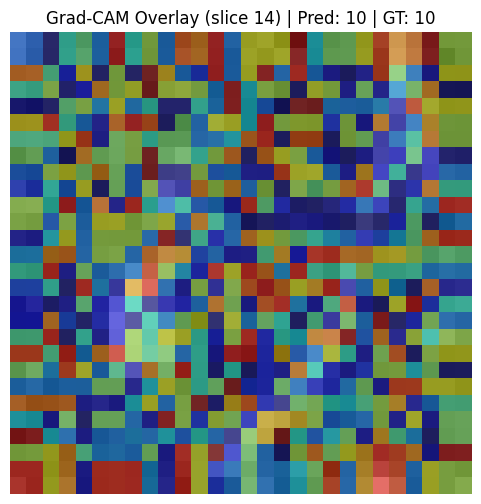

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval().to(device)

# === Choose target layer for GradCAM ===
target_layer = 'ltb3.conv.0'  # Change if needed
cam_extractor = GradCAM(model, target_layer=target_layer)

# === Load 1 test sample ===
inputs, targets = next(iter(test_loader))
input_tensor = inputs[0].unsqueeze(0).to(device)  # [1, 1, D, H, W]
true_label = targets[0].item()

# === Forward pass & CAM extraction ===
with torch.set_grad_enabled(True):
    scores = model(input_tensor)
    pred_class = scores.argmax(dim=1).item()
    cams = cam_extractor(pred_class, scores)  # list of CAMs

# === Get the CAM tensor ===
cam = cams[0]  # Could be [1, D, H, W] or [D, H, W]
if cam.dim() == 3:
    cam = cam.unsqueeze(0).unsqueeze(0)  # → [1, 1, D, H, W]
elif cam.dim() == 4:
    cam = cam.unsqueeze(0)               # → [1, 1, D, H, W]
# Else: already fine

# === Interpolate CAM to input shape ===
target_shape = input_tensor.shape[2:]  # [D, H, W]
cam_upsampled = F.interpolate(cam, size=target_shape, mode="trilinear", align_corners=False)

cam_volume = cam_upsampled.squeeze().cpu()  # [D, H, W]

# === Get input volume ===
input_volume = input_tensor.squeeze().cpu()  # [D, H, W]

# === Pick a middle slice ===
slice_idx = input_volume.shape[0] // 2
input_slice = input_volume[slice_idx]  # [H, W]
cam_slice = cam_volume[slice_idx]      # [H, W]

# === Normalize both slices ===
input_norm = (input_slice - input_slice.min()) / (input_slice.max() - input_slice.min() + 1e-6)
cam_norm = (cam_slice - cam_slice.min()) / (cam_slice.max() - cam_slice.min() + 1e-6)

# === Convert to PIL images ===
input_pil = to_pil_image(input_slice)
cam_pil = to_pil_image(cam_slice)

# Convert grayscale input to RGB for overlay
input_pil = input_pil.convert("RGB")

# === Overlay CAM ===
overlay = overlay_mask(input_pil, cam_pil, alpha=0.5)

# === Plot ===
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Grad-CAM Overlay (slice {slice_idx}) | Pred: {pred_class} | GT: {target_class}")
plt.axis("off")
plt.show()


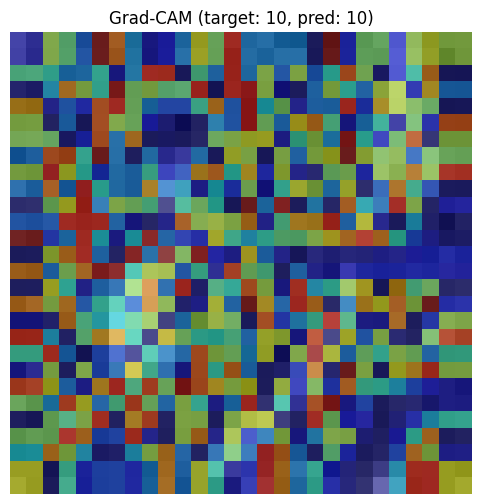

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

# === Prepare your model ===
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose a target layer name from your model — ltb3 is good
target_layer = "ltb3"

# Initialize GradCAM
cam_extractor = GradCAM(model, target_layer=target_layer)

# === Pick one test sample ===
inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
input_tensor = inputs[0].unsqueeze(0)  # [1, C, D, H, W]
target_class = targets[0].item()

# === Forward pass and CAM generation ===
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Generate CAM
cams = cam_extractor(pred_class, output)
cam = cams[0]

if cam.dim() == 3:
    cam = cam.unsqueeze(0).unsqueeze(0)  # → [1, 1, D, H, W]
elif cam.dim() == 4:
    cam = cam.unsqueeze(0)               # → [1, 1, D, H, W]
# === Interpolate CAM to match input size ===
target_shape = input_tensor.shape[2:]  # [D, H, W]
cam_upsampled = F.interpolate(cam, size=target_shape, mode="trilinear", align_corners=False)

cam_volume = cam_upsampled.squeeze().cpu()  # [D, H, W]


# === Normalize input volume ===
input_volume = input_tensor.squeeze().cpu()  # [D, H, W]
input_volume = (input_volume - input_volume.min()) / (input_volume.max() - input_volume.min())

# === Choose center slice ===
slice_idx = input_volume.shape[0] // 2
input_slice = input_volume[slice_idx]  # [H, W]
cam_slice = cam_volume[slice_idx]      # [H, W]

# Normalize CAM slice
cam_slice = (cam_slice - cam_slice.min()) / (cam_slice.max() - cam_slice.min())

# Convert grayscale input to RGB for overlay
input_pil = input_pil.convert("RGB")

# === Overlay CAM ===
overlay = overlay_mask(input_pil, cam_pil, alpha=0.5)

# === Plot result ===
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Grad-CAM (target: {target_class}, pred: {pred_class})")
plt.axis('off')
plt.show()
